## ONNX Model Export

In [1]:
import torchvision
import torch

def normalize(img, img_mean, img_scale):
    """
    all numpy functions are tensor/vector operations i.e. operations are broadcasted
    """
    img = np.array(img, dtype=np.float32)
    img = (img - img_mean) * img_scale
    return img


def preprocess_image(img):
    """
    1. normalize and tranpose (i.e. switch the dimensions to (720,1280,3) (height,width,channels)
    2. convert to the correct tensor shape and data type
    """
    img = cv2.resize(img, (640,360))
    img = normalize(img, [128,128,128] ,1/256).transpose(2,0,1)
    return np.expand_dims(img,0).astype(np.float16)

# dummy_input = torch.randn(1, 3, 360, 640, device='cuda').half()
dummy_input = torch.randn(3, 360, 640, device='cuda').half()
# dummy_input = torch.randn(1, 3, 720, 1280, device='cuda')
# dummy_input = torch.randn(1, 3, 180, 320, device='cuda').half()

input_names = [ "input" ]
output_names = [ "output" ]

model = net.cuda()
model = model.half()

torch.onnx.export(model, dummy_input, "pose360smallfloat16.onnx", verbose=True, input_names=input_names, output_names=output_names)

NameError: name 'net' is not defined

In [15]:
model.eval()(torch.tensor(preprocess_image(img))[0].cuda()).shape

torch.Size([19, 45, 80])

---
# Main Code

In [1]:
import argparse

import cv2
import numpy as np
import torch

from models.with_mobilenet import PoseEstimationWithMobileNet, PrunedPoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
from val import normalize, pad_width

In [2]:
class ImageReader(object):
    def __init__(self, file_names):
        self.file_names = file_names
        self.max_idx = len(file_names)

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx == self.max_idx:
            raise StopIteration
        img = cv2.imread(self.file_names[self.idx], cv2.IMREAD_COLOR)
        if img.size == 0:
            raise IOError('Image {} cannot be read'.format(self.file_names[self.idx]))
        self.idx = self.idx + 1
        return img


class VideoReader(object):
    def __init__(self, file_name):
        self.file_name = file_name
        try:  # OpenCV needs int to read from webcam
            self.file_name = int(file_name)
        except ValueError:
            pass

    def __iter__(self):
        self.cap = cv2.VideoCapture(self.file_name)
        if not self.cap.isOpened():
            raise IOError('Video {} cannot be opened'.format(self.file_name))
        return self

    def __next__(self):
        was_read, img = self.cap.read()
        if not was_read:
            raise StopIteration
        return img


def infer_fast(net, img, net_input_height_size, stride, upsample_ratio, cpu,
               pad_value=(0, 0, 0), img_mean=(128, 128, 128), img_scale=1/256):
    height, width, _ = img.shape
    scale = net_input_height_size / height

    scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    scaled_img = normalize(scaled_img, img_mean, img_scale)
    min_dims = [net_input_height_size, max(scaled_img.shape[1], net_input_height_size)]
    padded_img, pad = pad_width(scaled_img, stride, pad_value, min_dims)

    tensor_img = torch.from_numpy(padded_img).permute(2, 0, 1).unsqueeze(0).float()
    if not cpu:
        tensor_img = tensor_img.cuda()

    stages_output = net(tensor_img)

    stage2_heatmaps = stages_output[-2]
    heatmaps = np.transpose(stage2_heatmaps.squeeze().cpu().data.numpy(), (1, 2, 0))
    heatmaps = cv2.resize(heatmaps, (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)

    stage2_pafs = stages_output[-1]
    pafs = np.transpose(stage2_pafs.squeeze().cpu().data.numpy(), (1, 2, 0))
    pafs = cv2.resize(pafs, (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)
    return heatmaps, pafs, scale, pad

def get_raw_outputs(net, img, net_input_height_size, stride, upsample_ratio, cpu,
               pad_value=(0, 0, 0), img_mean=(128, 128, 128), img_scale=1/256):
    height, width, _ = img.shape
    scale = net_input_height_size / height

    scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    scaled_img = normalize(scaled_img, img_mean, img_scale)
    min_dims = [net_input_height_size, max(scaled_img.shape[1], net_input_height_size)]
    padded_img, pad = pad_width(scaled_img, stride, pad_value, min_dims)

    tensor_img = torch.from_numpy(padded_img).permute(2, 0, 1).unsqueeze(0).float()
    if not cpu:
        tensor_img = tensor_img.cuda()

    stages_output = net(tensor_img)
    return stages_output

def run_demo(net, image_provider, height_size, cpu, track, smooth):
    net = net.eval()
    if not cpu:
        net = net.cuda()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for img in image_provider:
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = infer_fast(net, img, height_size, stride, upsample_ratio, cpu)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
            pose = Pose(pose_keypoints, pose_entries[n][18])
            current_poses.append(pose)

        if track:
            track_poses(previous_poses, current_poses, smooth=smooth)
            previous_poses = current_poses
        for pose in current_poses:
            pose.draw(img)
        img = cv2.addWeighted(orig_img, 0.6, img, 0.4, 0)
        for pose in current_poses:
            cv2.rectangle(img, (pose.bbox[0], pose.bbox[1]),
                          (pose.bbox[0] + pose.bbox[2], pose.bbox[1] + pose.bbox[3]), (0, 255, 0))
            if track:
                cv2.putText(img, 'id: {}'.format(pose.id), (pose.bbox[0], pose.bbox[1] - 16),
                            cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255))
        cv2.imshow('Lightweight Human Pose Estimation Python Demo', img)
        key = cv2.waitKey(delay)
        if key == 27:  # esc
            return
        elif key == 112:  # 'p'
            if delay == 33:
                delay = 0
            else:
                delay = 33

In [3]:
kpt_names = ['nose', 'neck',
                 'r_sho', 'r_elb', 'r_wri', 'l_sho', 'l_elb', 'l_wri',
                 'r_hip', 'r_knee', 'r_ank', 'l_hip', 'l_knee', 'l_ank',
                 'r_eye', 'l_eye',
                 'r_ear', 'l_ear']

#points of interest
poi = [0, 1, 2, 5, 14, 15]
for i in poi:
    print(kpt_names[i])

nose
neck
r_sho
l_sho
r_eye
l_eye


In [4]:
class Args(object):
    def __init__(self):
        pass

In [5]:
args = Args()
args.video = 0
args.checkpoint_path = 'checkpoint_iter_370000.pth'
args.images = ''
args.height_size = 256
args.cpu = None
args.track = 1
args.smooth = 1

In [6]:
# to load a pruned version of the network
net = PrunedPoseEstimationWithMobileNet()
checkpoint = torch.load(args.checkpoint_path, map_location='cpu')
load_state(net, checkpoint)

In [7]:
# original loading
net = PoseEstimationWithMobileNet()
checkpoint = torch.load(args.checkpoint_path, map_location='cpu')
load_state(net, checkpoint)

frame_provider = ImageReader(args.images)
if args.video != '':
    frame_provider = VideoReader(args.video)
else:
    args.track = 0

In [8]:
img = cv2.imread('calibration/test2.jpg')

In [9]:
import matplotlib.pyplot as plt

In [10]:
def infer(img, net):
    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    
    heatmaps, pafs, scale, pad = infer_fast(net, img, args.height_size, stride, upsample_ratio, args.cpu)
    # heatmaps = heatmaps[:,:,poi]
    # pafs = pafs[:,:,[x for y in [[2*x,2*x+1] for x in poi] for x in y]]

    total_keypoints_num = 0
    all_keypoints_by_type = []
    for kpt_idx in range(num_keypoints):  # 19th for bg
        total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

    pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)

    for kpt_id in range(all_keypoints.shape[0]):
        all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
        all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
    current_poses = []
    for n in range(len(pose_entries)):
        if len(pose_entries[n]) == 0:
            continue
        pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
        for kpt_id in range(num_keypoints):
            if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
        pose = Pose(pose_keypoints, pose_entries[n][18])
        current_poses.append(pose)
      
    return current_poses

In [11]:
stride = 8
upsample_ratio = 4
num_keypoints = Pose.num_kpts
previous_poses = []
delay = 33
raw = get_raw_outputs(net.cuda().eval(), img, args.height_size, stride, upsample_ratio, args.cpu)

In [12]:
img = cv2.imread('calibration/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
raw = get_raw_outputs(net, img, args.height_size, stride, upsample_ratio, args.cpu)

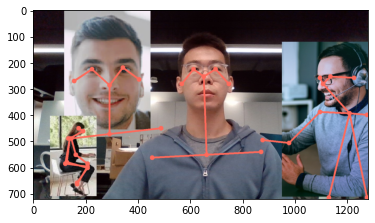

In [13]:
current_poses = infer(img, net.cuda().eval())
if len(current_poses):
    for p in current_poses: 
        p.draw(img)
plt.imshow(img)
plt.show()

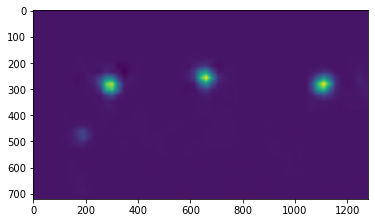

In [14]:
plt.imshow(np.expand_dims(cv2.resize(np.squeeze(raw[0][:,0,:].cpu().detach().numpy()), (1280,720)),2))

In [15]:
plt.imshow(0.8*np.array(img*mask, dtype=np.float32)/255 + 0.2*(img/255))

NameError: name 'mask' is not defined

In [17]:
for i in plt.imshow(np.squeeze(raw[1][:,,:,:].cpu().detach().numpy()))

SyntaxError: invalid syntax (<ipython-input-17-d6cf03b9bbf4>, line 1)

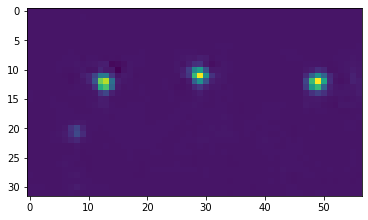

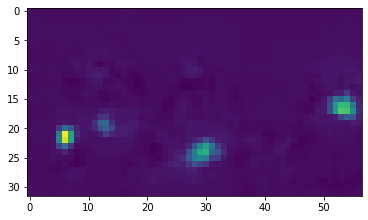

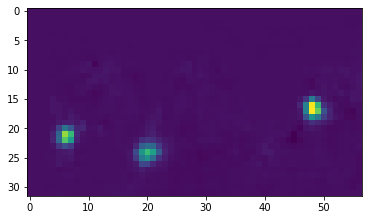

In [18]:
for i in range(3):
    plt.imshow(np.squeeze(raw[0][:,i,:,:].cpu().detach().numpy()))
    plt.show()

In [19]:
def draw_point(img, kp, scale, size=13):
    x = int(kp[0]/scale*2)
    y = int(kp[1]/scale*2)
    print(x,y)
    img[y-size:y+size,x-size:x+size,:] = 255
    return img

def show_points(all_keypoints):
    for k in all_keypoints:
        if len(k):
            draw_point(img, k[0], scale)
    plt.imshow(img)

In [20]:
"""
This processes the keypoints to obtain signals such as neck angle etc.
Inputs:
- keypoints      x and y positions of keypoints in the image frame

Outputs (signals):
- sho_angle      shoulder angle measured in degrees relative to the horizon
- sho_distance   shoulder distance in arbitrary unit (since actual distance depends on
                 camera's focal length and user's shoulder width, which are both unknown)
- sho_y          shoulder y-position in image frame (the average of left & right shoulders)
- neck_angle     angle in degrees of baseOfNeck-to-nose line to the line perpendicular to the shoulders
- eye_distance   eye-to-camera distance in arbitrary unit
- head_pitch     based on how low the tip of the nose is, relative to the eyes
"""
def process_kps(kp):
    nose = kp[0]
    neck = kp[1]
    r_sho = kp[2]
    l_sho = kp[5]

    sho_angle = np.arctan((r_sho[1] - l_sho[1])/(r_sho[0] - l_sho[0]))
    sho_angle *= (180/np.pi)

    sho_width = np.linalg.norm(r_sho - l_sho)
    sho_distance = 100/sho_width

    
    sho_y = np.mean([neck[1], r_sho[1], l_sho[1]])

    neck_len = np.linalg.norm(kp[0]-kp[1])
    abs_neck_angle = np.arctan((nose[0] - neck[0])/(nose[1] - neck[1]))
    abs_neck_angle *= (180/np.pi)

    neck_angle = abs_neck_angle + sho_angle

    r_eye, l_eye = kp[14], kp[15]
    interocular_distance = np.linalg.norm(r_eye - l_eye)
    eye_distance = 10/interocular_distance

    # nose_down: measured by drawing a line connecting the eyes,
    # then calculating the shortest distance of nose to the line.
    # the further the nose is below the eyes, the more downwards facing
    # negative = down
    nose_down = np.cross(r_eye - l_eye, nose - l_eye)/np.linalg.norm(r_eye - l_eye)
    
    # head_pitch: calculated by nose_down/interocular_distance
    # more negative = more down facing
    head_pitch = nose_down/interocular_distance
    return sho_angle, sho_distance, sho_y, neck_angle, eye_distance, head_pitch

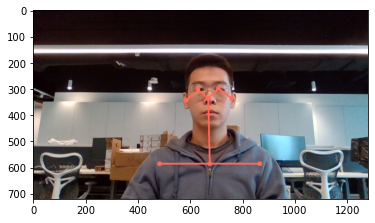

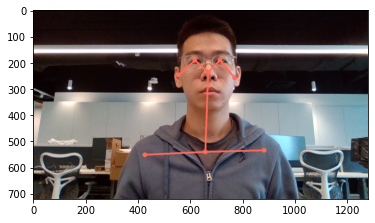

In [21]:
import os
goods = [x for x in os.listdir("calibration") if x[:4] == 'good']
bads = [x for x in os.listdir("calibration") if x[:3] == 'bad']
for n, img_name in enumerate(goods):
    if n < 9:
        img = plt.imread("calibration/" + img_name)
        current_poses = infer(img, net.cuda().eval())
        if len(current_poses):
            current_pose = current_poses[0]
        current_pose.draw(img)
        plt.imshow(img)
        plt.show()

In [22]:
goods = [x for x in os.listdir("calibration") if x[:4] == 'good']
good_calibrations = []
for n, img_name in enumerate(goods):
    img = plt.imread("calibration/" + img_name)
    current_poses = infer(img, net.cuda().eval())
    if len(current_poses):
            current_pose = current_poses[0]
    good_calibrations.append(process_kps(current_pose.keypoints))
good_calibrations

[(-0.0,
  0.26109660574412535,
  585.0,
  1.385917850812192,
  0.12794253088668606,
  -0.46603372073989185),
 (-2.135038106057741,
  0.21914600837330508,
  541.6666666666666,
  -4.207336551676839,
  0.10416666666666667,
  -0.46875)]

### Signals
* shoulders angle
* shoulders distance (using width)
* neck angle relative to shoulders (deviation from upright)
* head pitch `nose_down/eye_distance`
* neck-nose length (not used)

### Posture metrics
"no data" if there's no shoulders/neck/nose/eyes data
<br>all compared to calibration data. 1 or more calibration image of good posture is taken, a new posture is compared with all of them, then the best score is taken.
* Head pitch (i.e. up/down orientation) **20%**
    * **TO BE DECIDED**
* Uprightness 
    * sideways 
        * shoulders squared **20%**
            * using the sigmoid function score = -1/(1+e^(3-x/4)) + 1.047 for {x >= 0} where x = abs(shoulder_angle)
            * at 5,10,15,20,25$^{\circ}$, scores are 90%, 67%, 37%, 16%, 8%
        * neck 90$^{\circ}$ relative to shoulders **20%**
            * using the sigmoid function score = -1/(1+e^(3-x/4)) + 1.047 for {x >= 0} where x = abs(neck_angle)
    * front/back
        * eyes not much closer to the screen **20%**
            * using the sigmoid function score = -1/(1+e^(3-x/9)) + 1.047 for {x >= 0} where x = %decrease in eye_distance (distance to camera)
            * at 10,20,30,40,50% closer, scores are 91%, 72%, 54%, 23%, 11%
        * slouching: if shoulders go lower/closer) **20%**  (**NOTE! THIS IS NOT TRANSLATION-INVARIANT**)
            * multiplier = 1/(1+e^(3-x)) where x = %decrease in shoulder distance
            * score = 1 - {multiplier * 1/(1+e^(3-x/3))} where x = %decrease in shoulder y-position, (normed by shoulder width) x = min(1,x)
            
extras:
* notify users to recalibrate if posture consistently deviates a lot from calibrations

`sho_angle, sho_distance, sho_y, neck_angle, eye_distance, head_pitch`

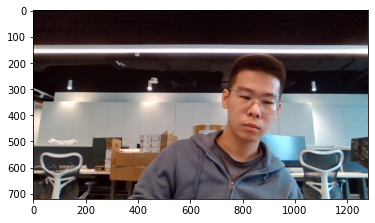

In [23]:
plt.imshow(plt.imread('calibration/bad2.jpg'))

In [24]:
calib = good_calibrations[0]
frame = process_kps(infer(plt.imread('calibration/bad2.jpg'),net)[0].keypoints)

In [25]:
def sigmoid(a,b,c,d,x):
    return a/(1+np.exp(b-x/c)) + d

In [26]:
def get_scores(calib, frame, calib_height, frame_height): #signals
    sho_square_score = sigmoid(-1,3,4, 1.047, abs(calib[0] - frame[0]))
    neck_angle_score = sigmoid(-1,3,4, 1.047, abs(calib[3] - frame[3]))

    change_in_eyescreen_distance = frame[4]/calib[4] - 1

    if change_in_eyescreen_distance < 0:
        eyescreen_distance_score = sigmoid(-1,3,9, 1.047, abs(change_in_eyescreen_distance)*100) 
    else:
        eyescreen_distance_score = 1

    change_in_shoulder_distance = np.min([0,frame[1]/calib[1] - 1]) # % change, only capture negative
    slouch_multiplier = sigmoid(1,3,1,0, abs(change_in_shoulder_distance)*100)

    change_in_shoulder_y_norm = (frame[2]/frame_height - calib[2]/calib_height)/(100/(calib[1]*calib_height))
    if change_in_shoulder_y_norm > 0:
        slouch_score = 1 - slouch_multiplier * sigmoid(1,3,2,0,change_in_shoulder_y_norm*100)
    else:
        slouch_score = 1
        
    return [sho_square_score, neck_angle_score, eyescreen_distance_score, slouch_score]

0.216 0.111


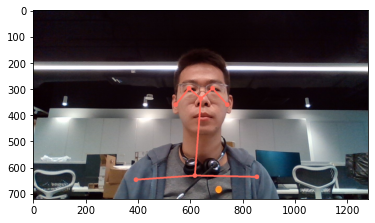

0.195 0.085


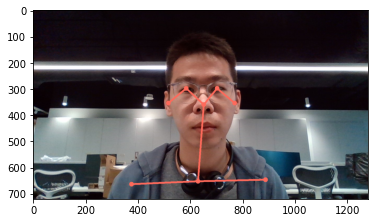

0.179 0.061


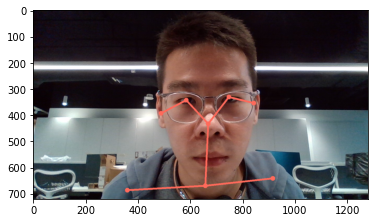

In [27]:
i = [x for x in os.listdir("calibration") if x[:1] == 'i']
for n, img_name in enumerate(i):
    img = plt.imread("calibration/" + img_name)
    current_poses = infer(img, net.cuda().eval())
    if len(current_poses):
        current_pose = current_poses[0]
    current_pose.draw(img)
    signals = process_kps(current_pose.keypoints)
    print(signals[1].round(3), signals[4].round(3))
    plt.imshow(img)
    plt.show()

[-2.3685, 0.2431, 552.6667, -0.2546, 0.119, -0.3333]


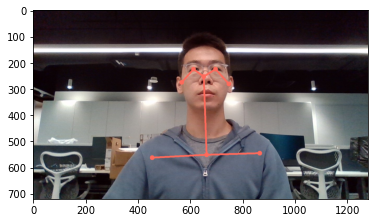

[-0.8364, 0.2433, 564.0, 0.3613, 0.119, -0.4048]


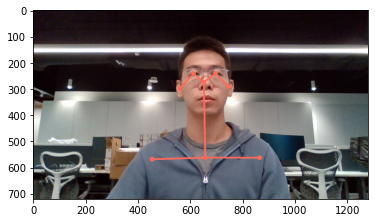

[-0.8384, 0.2439, 575.0, 0.2032, 0.119, -0.4762]


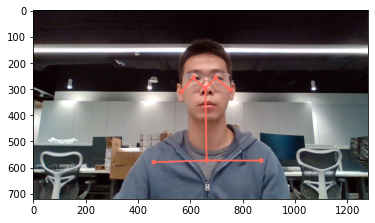

[-3.0406, 0.2306, 608.6667, -3.0406, 0.119, -0.3929]


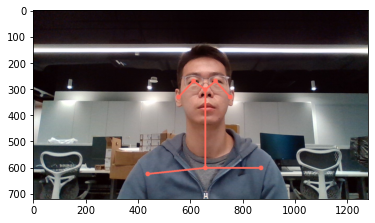

In [29]:
slouch = [x for x in os.listdir("calibration") if x[:6] == 'slouch']
for n, img_name in enumerate(slouch):
    img = plt.imread("calibration/" + img_name)
    current_poses = infer(img, net.cuda().eval())
    if len(current_poses):
        current_pose = current_poses[0]
    current_pose.draw(img)
    signals = process_kps(current_pose.keypoints)
    print([x.round(4) for x in signals])
    plt.imshow(img)
    plt.show()

# LOCAL DEMO

In [30]:
import pandas as pd
import cv2

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

In [31]:
def generate_live_plot(time_series, window_size=5, max_data_length=30):
    fig = Figure(figsize=(10, 4), dpi=100)
    canvas = FigureCanvasAgg(fig)
    ax = fig.gca()
    ax.set_ylim([-0.1,1.1])
    time_series.reset_index(drop=True).rolling(window_size,min_periods=1).mean().iloc[-max_data_length:].plot(ax=ax)
    ax.legend(loc='upper right')
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    live_plot = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    return live_plot

In [32]:
def generate_live_plot4(time_series, window_size=5, max_data_length=20):
    fig = Figure(figsize=(3, 6), dpi=100)
    canvas = FigureCanvasAgg(fig)
    
    labels = ['shoulder uprightness', 'neck uprightness', 'eye-screen distance', '"non-slouchness"']
    colors = ['gray','gray','gray','gray']
    axs = fig.subplots(4)
    for i,col in enumerate(time_series.columns):
        axs[i].set_ylim([-0.2,1.2])
#         axs[i].axis('off')
        axs[i].axes.get_xaxis().set_visible(False)
        time_series[col].reset_index(drop=True).rolling(window_size,min_periods=1).mean().iloc[-max_data_length:].plot.area(ax=axs[i],label=labels[i],color=colors[i], alpha=0.4)
        axs[i].legend(loc='upper left')
        score = time_series[col].iloc[-1]*0.3
        axs[i].set_facecolor((1-score*0.8, 0.7+score, 0.7))
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    live_plot = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    return live_plot

In [33]:
import os
right = [x for x in os.listdir("calibration") if x[:4] == 'aayu']
right_calibrations = []
for n, img_name in enumerate(right):
    img = plt.imread("calibration/" + img_name)
    current_poses = infer(img, net.cuda().eval())
    if len(current_poses):
            current_pose = current_poses[0]
    right_calibrations.append(process_kps(current_pose.keypoints))
right_calibrations

[(-0.0,
  0.26109660574412535,
  523.0,
  -0.0,
  0.1282051282051282,
  -0.358974358974359)]

# 1. Calibration
The optimal posture of you is recorded as a reference.

In [34]:
import cv2

In [101]:
def get_mainpose_idx(current_poses, image_width):
    x_poss = []
    for pose in current_poses:
        kps = pose.keypoints
        x_poss.append(abs(kps[:,0][kps[:,0] > 0].mean()-image_width/2))
    return x_poss.index(min(x_poss))

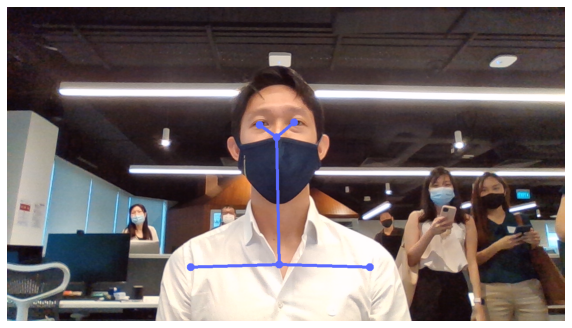

In [115]:
image_width = 1280
image_height = 720

cap = cv2.VideoCapture(0)
cap.set(3,image_width)
cap.set(4,image_height)

_, calib_img = cap.read()
_, calib_img = cap.read()

plt.figure(figsize = (10,20))
plt.axis('off')
cap.release()

current_poses = infer(calib_img, net.cuda().eval())
if len(current_poses):
    current_pose = current_poses[get_mainpose_idx(current_poses, 1280)]
    current_pose.keypoints[kp_out,:] = -1
    current_pose.draw(calib_img)
    right_calibrations.append(process_kps(current_pose.keypoints))
calib = right_calibrations[0]


plt.imshow(cv2.cvtColor(calib_img, cv2.COLOR_BGR2RGB));

In [108]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [116]:
cap = cv2.VideoCapture(0)
cap.set(3,image_width)
cap.set(4,image_height)
time_series = pd.DataFrame()

current_pose.keypoints[kp_out,:] = -1
previous_pose = current_pose

while(True):
    ret, img = cap.read()
    current_poses = def (img,net)
    if len(current_poses):
        current_pose = current_poses[get_mainpose_idx(current_poses, image_width)]
        
        #tracking
        current_pose.keypoints[kp_out,:] = -1
        # only use prev pose if all keypoints are captured
        if ~np.any(current_pose.keypoints[poi,:] < 0):
            current_pose.keypoints = 0.5*previous_pose.keypoints + 0.5*current_pose.keypoints
            current_pose.keypoints[current_pose.keypoints < 0] = -1
            previous_pose = current_pose
        
        signals = process_kps(current_pose.keypoints)
        time_series = time_series.append([get_scores(calib, signals,calib_height=720,frame_height=img.shape[0])])
        
        # visualizations
        
        current_pose.draw(img)
        
        live_plot = generate_live_plot4(time_series, 5,10)[:,:,:3][:,:,::-1]
        h,w,_ = live_plot.shape
        m = (45,5) #margin
        img[m[0]:h-m[0], m[1]:w-m[1]] = live_plot[m[0]:h-m[0], m[1]:w-m[1]]     

        cv2.imshow('video', img) 
        
#         cv2.imshow('plot', live_plot)
     
    if cv2.waitKey(1) == 27: # when escape key is pressed
        break
        
cap.release()
cv2.destroyAllWindows()

C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sfsy1\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sfsy1\miniconda3\en

KeyboardInterrupt: 

In [43]:
cap.release()
cv2.destroyAllWindows()